In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
#MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
#MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [4]:

"""#MMD Evaluation Metric Definition
Using MMD to determine the similarity between distributions
PDIST code comes from torch-two-sample utils code: 
    https://github.com/josipd/torch-two-sample/blob/master/torch_two_sample/util.py
"""

def pdist(sample_1, sample_2, norm=2, eps=1e-5):
    r"""Compute the matrix of all squared pairwise distances.
    Arguments
    ---------
    sample_1 : torch.Tensor or Variable
        The first sample, should be of shape ``(n_1, d)``.
    sample_2 : torch.Tensor or Variable
        The second sample, should be of shape ``(n_2, d)``.
    norm : float
        The l_p norm to be used.
    Returns
    -------
    torch.Tensor or Variable
        Matrix of shape (n_1, n_2). The [i, j]-th entry is equal to
        ``|| sample_1[i, :] - sample_2[j, :] ||_p``."""
    n_1, n_2 = sample_1.size(0), sample_2.size(0)
    norm = float(norm)
    
    if norm == 2.:
        norms_1 = torch.sum(sample_1**2, dim=1, keepdim=True)
        norms_2 = torch.sum(sample_2**2, dim=1, keepdim=True)
        norms = (norms_1.expand(n_1, n_2) +
                 norms_2.transpose(0, 1).expand(n_1, n_2))
        distances_squared = norms - 2 * sample_1.mm(sample_2.t())
        return torch.sqrt(eps + torch.abs(distances_squared))
    else:
        dim = sample_1.size(1)
        expanded_1 = sample_1.unsqueeze(1).expand(n_1, n_2, dim)
        expanded_2 = sample_2.unsqueeze(0).expand(n_1, n_2, dim)
        differences = torch.abs(expanded_1 - expanded_2) ** norm
        inner = torch.sum(differences, dim=2, keepdim=False)
        return (eps + inner) ** (1. / norm)

def permutation_test_mat(matrix,
                         n_1,  n_2,  n_permutations,
                          a00=1,  a11=1,  a01=0):
    """Compute the p-value of the following statistic (rejects when high)
        \sum_{i,j} a_{\pi(i), \pi(j)} matrix[i, j].
    """
    n = n_1 + n_2
    pi = np.zeros(n, dtype=np.int8)
    pi[n_1:] = 1

    larger = 0.
    count = 0
    
    for sample_n in range(1 + n_permutations):
        count = 0.
        for i in range(n):
            for j in range(i, n):
                mij = matrix[i, j] + matrix[j, i]
                if pi[i] == pi[j] == 0:
                    count += a00 * mij
                elif pi[i] == pi[j] == 1:
                    count += a11 * mij
                else:
                    count += a01 * mij
        if sample_n == 0:
            statistic = count
        elif statistic <= count:
            larger += 1

        np.random.shuffle(pi)

    return larger / n_permutations

"""Code from Torch-Two-Samples at https://torch-two-sample.readthedocs.io/en/latest/#"""

class MMDStatistic:
    r"""The *unbiased* MMD test of :cite:`gretton2012kernel`.
    The kernel used is equal to:
    .. math ::
        k(x, x') = \sum_{j=1}^k e^{-\alpha_j\|x - x'\|^2},
    for the :math:`\alpha_j` proved in :py:meth:`~.MMDStatistic.__call__`.
    Arguments
    ---------
    n_1: int
        The number of points in the first sample.
    n_2: int
        The number of points in the second sample."""

    def __init__(self, n_1, n_2):
        self.n_1 = n_1
        self.n_2 = n_2

        # The three constants used in the test.
        self.a00 = 1. / (n_1 * (n_1 - 1))
        self.a11 = 1. / (n_2 * (n_2 - 1))
        self.a01 = - 1. / (n_1 * n_2)

    def __call__(self, sample_1, sample_2, alphas, ret_matrix=False):
        r"""Evaluate the statistic.
        The kernel used is
        .. math::
            k(x, x') = \sum_{j=1}^k e^{-\alpha_j \|x - x'\|^2},
        for the provided ``alphas``.
        Arguments
        ---------
        sample_1: :class:`torch:torch.autograd.Variable`
            The first sample, of size ``(n_1, d)``.
        sample_2: variable of shape (n_2, d)
            The second sample, of size ``(n_2, d)``.
        alphas : list of :class:`float`
            The kernel parameters.
        ret_matrix: bool
            If set, the call with also return a second variable.
            This variable can be then used to compute a p-value using
            :py:meth:`~.MMDStatistic.pval`.
        Returns
        -------
        :class:`float`
            The test statistic.
        :class:`torch:torch.autograd.Variable`
            Returned only if ``ret_matrix`` was set to true."""
        sample_12 = torch.cat((sample_1, sample_2), 0)
        distances = pdist(sample_12, sample_12, norm=2)

        kernels = None
        for alpha in alphas:
            kernels_a = torch.exp(- alpha * distances ** 2)
            if kernels is None:
                kernels = kernels_a
            else:
                kernels = kernels + kernels_a

        k_1 = kernels[:self.n_1, :self.n_1]
        k_2 = kernels[self.n_1:, self.n_1:]
        k_12 = kernels[:self.n_1, self.n_1:]

        mmd = (2 * self.a01 * k_12.sum() +
               self.a00 * (k_1.sum() - torch.trace(k_1)) +
               self.a11 * (k_2.sum() - torch.trace(k_2)))
        if ret_matrix:
            return mmd, kernels
        else:
            return mmd


    def pval(self, distances, n_permutations=1000):
        r"""Compute a p-value using a permutation test.
        Arguments
        ---------
        matrix: :class:`torch:torch.autograd.Variable`
            The matrix computed using :py:meth:`~.MMDStatistic.__call__`.
        n_permutations: int
            The number of random draws from the permutation null.
        Returns
        -------
        float
            The estimated p-value."""
        if isinstance(distances, Variable):
            distances = distances.data
        return permutation_test_mat(distances.cpu().numpy(),
                                    self.n_1, self.n_2,
                                    n_permutations,
                                    a00=self.a00, a11=self.a11, a01=self.a01)
"""
This paper 
https://arxiv.org/pdf/1611.04488.pdf says that the most common way to 
calculate sigma is to use the median pairwise distances between the joint data.
"""

def pairwisedistances(X,Y,norm=2):
    dist = pdist(X,Y,norm)
    return np.median(dist.numpy())





# Imports and Pre-processing

In this section of the code, we import all the libraries and define the functions for the pre-processing of the dataset.  


In [10]:
#! pip uninstall tensorflow
#! pip install tensorflow==2.3.0

import tensorflow as tf
import os

from tensorflow.keras import layers, regularizers
#from torch_two_sample.statistics_diff import MMDStatistic
import torch
from tensorflow import lite

import matplotlib.pyplot as plt
import numpy as np
import random
import scipy.io

from IPython import display
from tqdm import tqdm
from shutil import copyfile
import pathlib


print(tf.__version__)


# from google.colab import drive
# drive.mount('/drive')


norm_value = 1 #2173


#################################################################################
#          Helper functions
#################################################################################
def test_show(generator, discriminator):
    noise = tf.random.normal([1, 125, 50])
    generated_ecg = generator(noise, training=False)
    print(generated_ecg.shape)
    plt.plot(generated_ecg[0, 0, :])
    plt.show()
    
    decision = discriminator(generated_ecg, training=False)
    print(decision)
    

def generate_and_save_ecg(model, epoch, test_input, save):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,3))
    plt.plot(predictions[0, 0, :] * norm_value)
    # plt.plot(predictions[0, 0, :])
    
    if save:
        plt.savefig('./ecg_at_epoch_{:04d}.png'.format(epoch))

    plt.show()
    

def prepare_data(dim):
#     copyfile(f"/drive/My Drive/Colab Notebooks/data/fix_signals_400.npy", "./fix_signals.npy")

    #Changes Philippe
    mat = scipy.io.loadmat(r"/content/drive/MyDrive/Colab Notebooks/ecg_GAN/interp_data_norm.mat")
    
    data = mat['interp_data'] 
    data = np.reshape(data, (data.shape[0],1,data.shape[1]))


    #data = np.load('./data/fix_signals_400.npy')
    #data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
    print('Data shape:', data.shape)


    data = data #/ norm_value # Normalize
    data = np.array(data, dtype='float32')
    data = data[:576]
    print(data.shape)
    print(np.amax(data))
    print(np.amin(data))

    plt.figure(figsize=(4,3))
    plt.plot(data[random.randint(0, data.shape[0]-1)][0])
    plt.show()

    train_size = int(data.shape[0] * 0.9)
    test_size = data.shape[0] - train_size
    print(train_size, test_size)

    # Batch and shuffle the data
    train_dataset = tf.data.Dataset.from_tensor_slices(data[:train_size]).shuffle(train_size).batch(BATCH_SIZE)
    test_dataset  = tf.data.Dataset.from_tensor_slices(data[train_size:]).shuffle(test_size).batch(1)

    seed = tf.random.normal(dim)
    
    return seed, train_dataset, test_dataset

2.9.2


# Generator and Discriminator Models

In this section, we define the functions for creating the Discriminator and Generator models. We then create them, and print out the summary of the two models shwocasing the parameters for each layer. 

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Input(shape=(100, 1)))

    #model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True)))

    model.add(layers.Conv1D(filters=64, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
  
    model.add(layers.Conv1D(filters=32, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.UpSampling1D(2))
    
    model.add(layers.Conv1D(filters=16, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1D(filters=8, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.UpSampling1D(2))
    
    model.add(layers.Conv1D(filters=1, kernel_size=16, strides=1, padding='same', activation='tanh'))
    
    model.add(layers.Permute((2, 1)))
    
    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
   
    model.add(layers.Input(shape=(1, 400)))
    model.add(layers.Permute((2, 1)))
    
    model.add(layers.Conv1D(filters=32, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    # model.add(layers.Dropout(0.4))

    model.add(layers.Conv1D(filters=64, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.MaxPool1D(pool_size=2))

    model.add(layers.Conv1D(filters=128, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    # model.add(layers.Dropout(0.4))

    model.add(layers.Conv1D(filters=256, kernel_size=16, strides=1, padding='same'))
    model.add(layers.LeakyReLU())

    model.add(layers.MaxPool1D(pool_size=2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator     = make_generator_model()
discriminator = make_discriminator_model()
    
generator.summary()
discriminator.summary()

# test_show(generator, discriminator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 100, 64)           1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100, 64)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 32)           32800     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100, 32)           0         
                                                                 
 up_sampling1d (UpSampling1D  (None, 200, 32)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 200, 16)           8208      
                                                        

# Prepare metrics for logging

In this section we define the discriminator and generator losses as well as the loss functions and optimizers. 

In [7]:
#################################################################################
#          Prepare metrics for logging
#################################################################################

# !rm -rf ./logs/

### discriminator loss ###
disc_log_dir = 'logs/gradient_tape/disc_loss'
disc_summary_writer = tf.summary.create_file_writer(disc_log_dir)
disc_losses = tf.keras.metrics.Mean('disc_loss', dtype=tf.float32)
disc_losses_list = []

### discriminator accuracy ###
fake_disc_accuracy = tf.keras.metrics.BinaryAccuracy('fake_disc_accuracy')
real_disc_accuracy = tf.keras.metrics.BinaryAccuracy('real_disc_accuracy')
fake_disc_accuracy_list, real_disc_accuracy_list = [], []

### generator loss ###
gen_log_dir = 'logs/gradient_tape/gen_loss'
gen_summary_writer = tf.summary.create_file_writer(gen_log_dir)
gen_losses = tf.keras.metrics.Mean('gen_loss', dtype=tf.float32)
gen_losses_list = []


#################################################################################
#          Prepare loss functions and optimizers
#################################################################################

# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(0.0002)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0002)

#Training

This part of the code defines the training functions of our models. 

In [8]:
disc_steps = 5

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".

@tf.function
def train_step(real_ecg, dim):
    noise = tf.random.normal(dim)

    for i in range(disc_steps):
        with tf.GradientTape() as disc_tape:
            generated_ecg = generator(noise, training=True)

            real_output = discriminator(real_ecg, training=True)
            fake_output = discriminator(generated_ecg, training=True)
            disc_loss = discriminator_loss(real_output, fake_output)
        


        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
        ### for tensorboard ###
        disc_losses.update_state(disc_loss)
        fake_disc_accuracy.update_state(tf.zeros_like(fake_output), fake_output)
        real_disc_accuracy.update_state(tf.ones_like(real_output), real_output)
        #######################
    
    with tf.GradientTape() as gen_tape:
        generated_ecg = generator(noise, training=True)
        fake_output = discriminator(generated_ecg, training=True)

        gen_loss = generator_loss(fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    ### for tensorboard ###
    gen_losses.update_state(gen_loss)
    #######################
    

def train(dataset, epochs, dim):
    for epoch in tqdm(range(epochs)):
    
        for batch in dataset:
            train_step(batch, dim)            
        disc_losses_list.append(disc_losses.result().numpy())
        gen_losses_list.append(gen_losses.result().numpy())
        
        fake_disc_accuracy_list.append(fake_disc_accuracy.result().numpy())
        real_disc_accuracy_list.append(real_disc_accuracy.result().numpy())
        
        ## for tensorboard ###
        with disc_summary_writer.as_default():
            tf.summary.scalar('loss', disc_losses.result(), step=epoch)
            tf.summary.scalar('fake_accuracy', fake_disc_accuracy.result(), step=epoch)
            tf.summary.scalar('real_accuracy', real_disc_accuracy.result(), step=epoch)
            
        with gen_summary_writer.as_default():
            tf.summary.scalar('loss', gen_losses.result(), step=epoch)
            
        disc_losses.reset_states()        
        gen_losses.reset_states()
        
        fake_disc_accuracy.reset_states()
        real_disc_accuracy.reset_states()
        #######################
        generate_and_save_ecg(generator, epochs, seed, False)
        generate_and_save_ecg(generator, epochs, seed, False)
        generate_and_save_ecg(generator, epochs, seed, False)
        # Save the model every 5 epochs
#         if (epoch + 1) % 5 == 0:
#             generate_and_save_ecg(generator, epochs, seed, False)
#             checkpoint.save(file_prefix = checkpoint_prefix)

    # Generate after the final epoch
    #display.clear_output(wait=True)
    generate_and_save_ecg(generator, epochs, seed, False)
    
#     generator.save('/content/drive/My Drive/Colab Notebooks/saved_models/generator_1500.h5')
#     discriminator.save('/content/drive/My Drive/Colab Notebooks/saved_models/discriminator_1500.h5')

# Dataset example

Plotting of a signal from our dataset.

Data shape: (565, 1, 400)
(565, 1, 400)
1.0
0.0


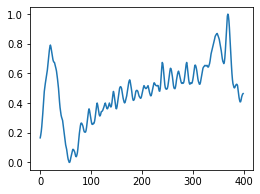

508 57


In [11]:
BATCH_SIZE = 64
noise_dim = [BATCH_SIZE, 100, 1]

seed, train_dataset, test_dataset = prepare_data(noise_dim)

# Training our model

Using the train function defined earlier, we can train the models using as inputs, our dataset, the number of epochs and the noise dimension (input to the generator). 

  0%|          | 0/60 [00:00<?, ?it/s]

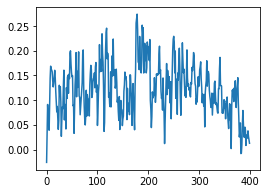

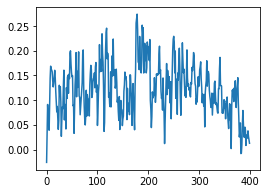

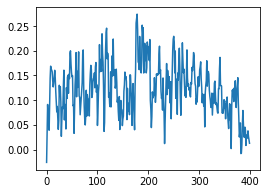

  2%|▏         | 1/60 [00:41<40:54, 41.61s/it]

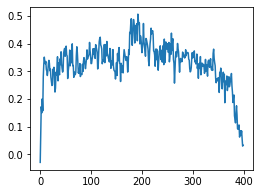

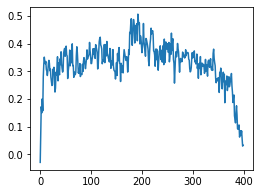

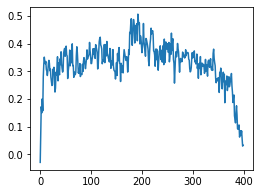

  3%|▎         | 2/60 [00:43<17:25, 18.02s/it]

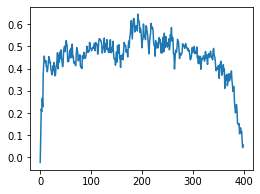

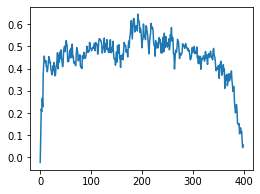

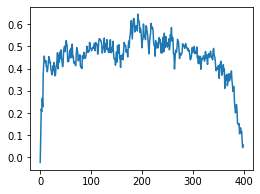

  5%|▌         | 3/60 [00:44<09:57, 10.48s/it]

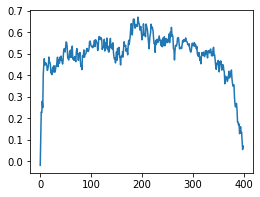

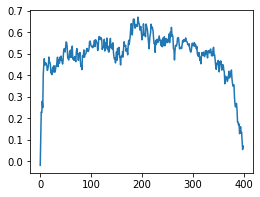

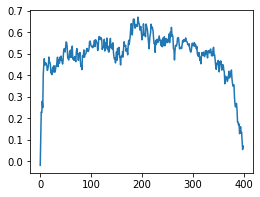

  7%|▋         | 4/60 [00:46<06:28,  6.94s/it]

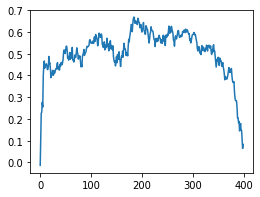

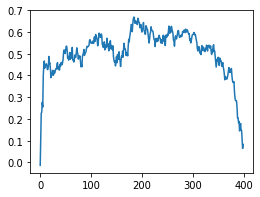

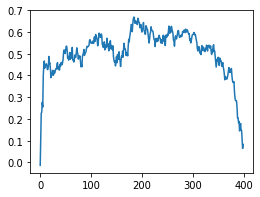

  8%|▊         | 5/60 [00:47<04:35,  5.00s/it]

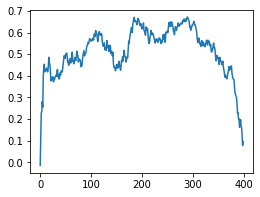

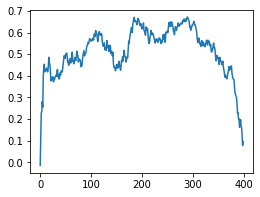

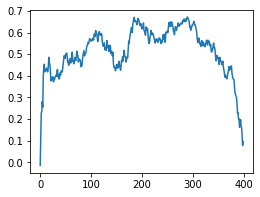

 10%|█         | 6/60 [00:49<03:26,  3.82s/it]

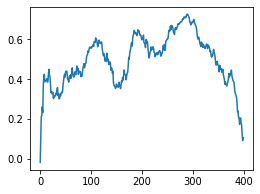

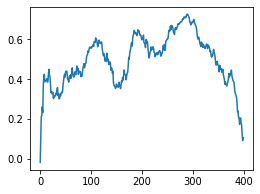

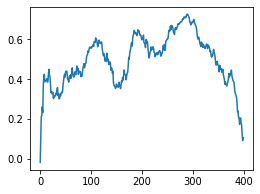

 12%|█▏        | 7/60 [00:50<02:41,  3.05s/it]

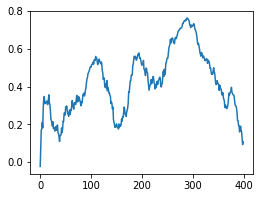

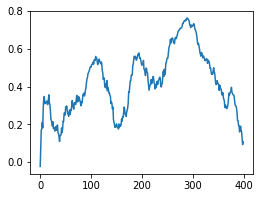

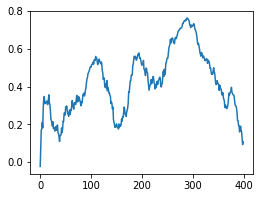

 13%|█▎        | 8/60 [00:52<02:13,  2.56s/it]

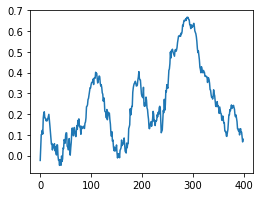

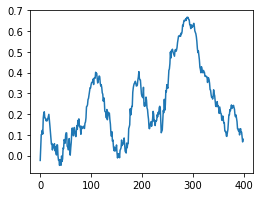

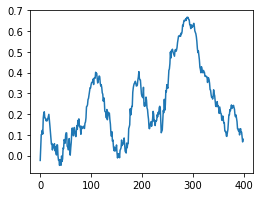

 15%|█▌        | 9/60 [00:53<01:54,  2.24s/it]

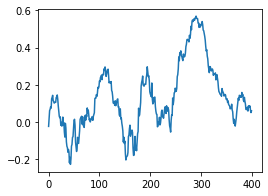

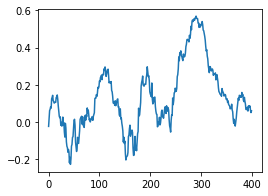

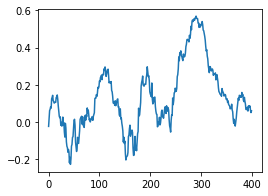

 17%|█▋        | 10/60 [00:55<01:40,  2.01s/it]

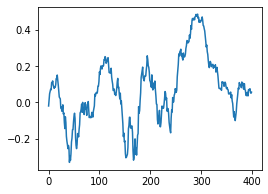

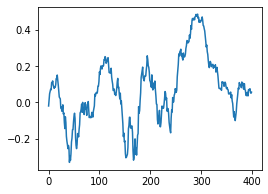

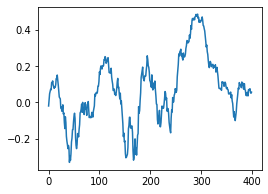

 18%|█▊        | 11/60 [00:56<01:31,  1.86s/it]

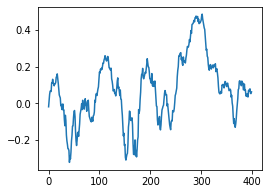

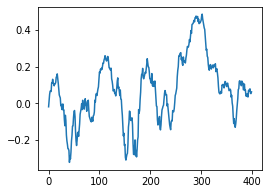

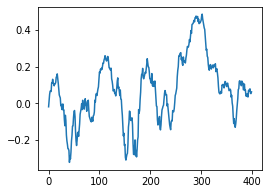

 20%|██        | 12/60 [00:58<01:24,  1.76s/it]

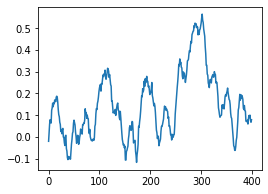

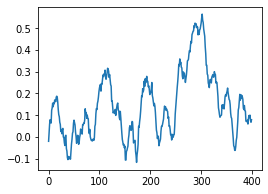

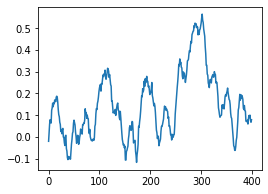

 22%|██▏       | 13/60 [00:59<01:19,  1.70s/it]

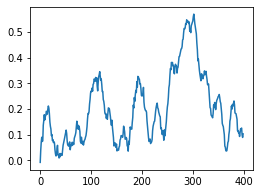

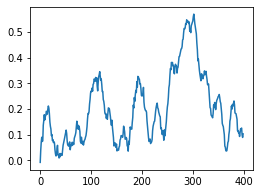

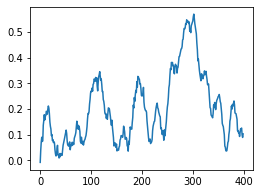

 23%|██▎       | 14/60 [01:01<01:16,  1.65s/it]

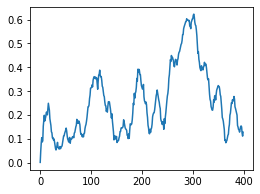

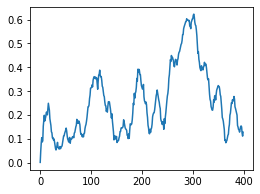

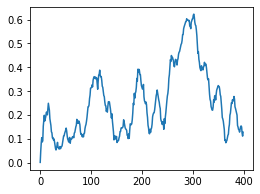

 25%|██▌       | 15/60 [01:02<01:12,  1.62s/it]

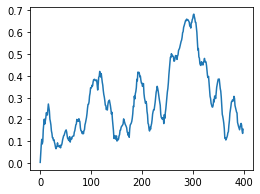

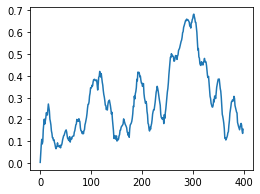

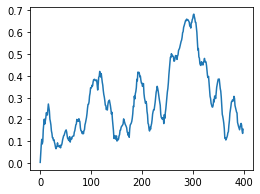

 27%|██▋       | 16/60 [01:04<01:10,  1.61s/it]

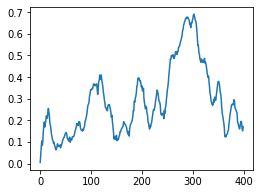

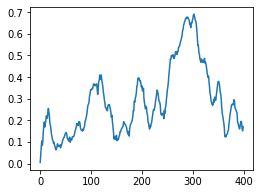

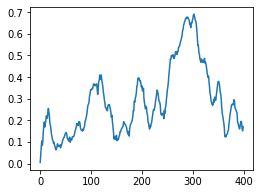

 28%|██▊       | 17/60 [01:06<01:08,  1.59s/it]

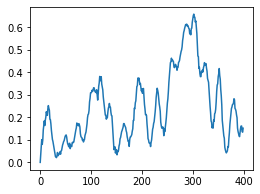

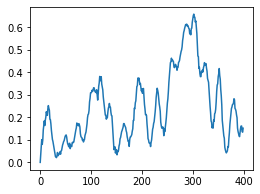

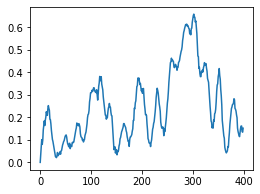

 30%|███       | 18/60 [01:07<01:06,  1.57s/it]

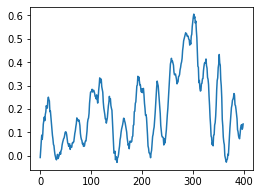

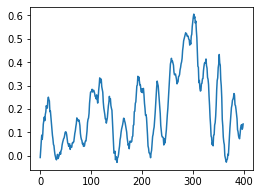

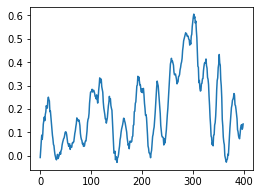

 32%|███▏      | 19/60 [01:09<01:04,  1.56s/it]

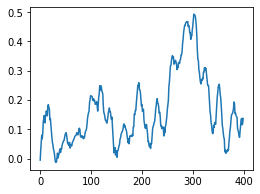

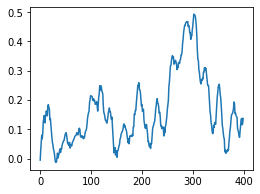

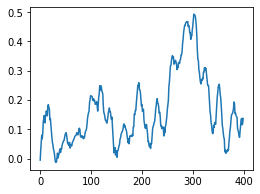

 33%|███▎      | 20/60 [01:10<01:02,  1.56s/it]

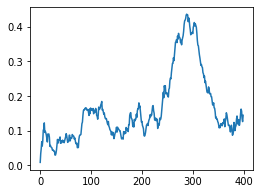

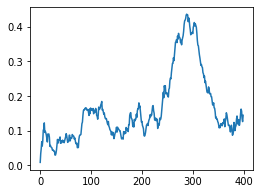

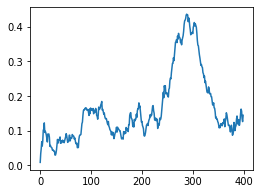

 35%|███▌      | 21/60 [01:12<01:00,  1.55s/it]

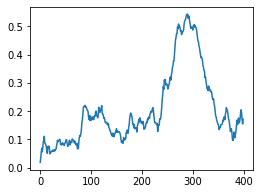

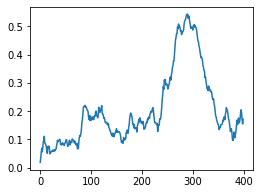

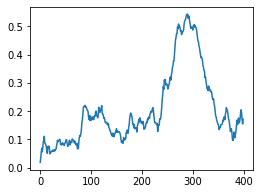

 37%|███▋      | 22/60 [01:13<00:58,  1.55s/it]

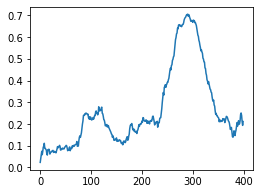

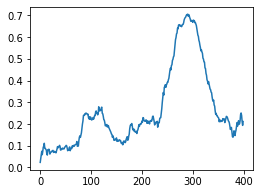

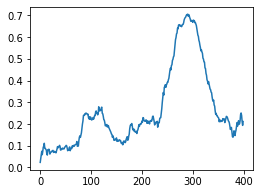

 38%|███▊      | 23/60 [01:15<01:01,  1.65s/it]

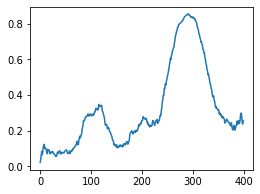

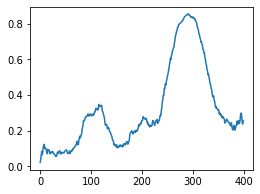

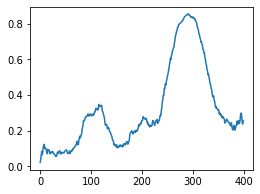

 40%|████      | 24/60 [01:17<01:00,  1.67s/it]

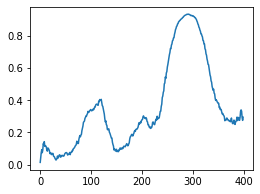

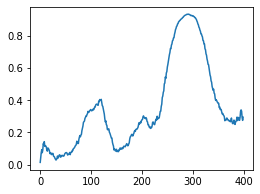

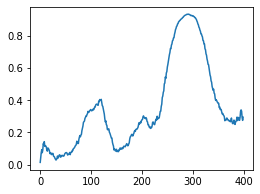

 42%|████▏     | 25/60 [01:19<00:59,  1.71s/it]

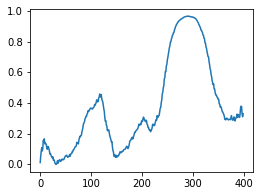

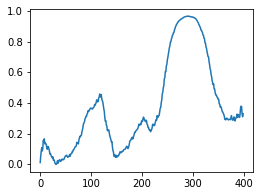

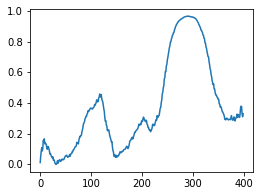

 43%|████▎     | 26/60 [01:20<00:56,  1.66s/it]

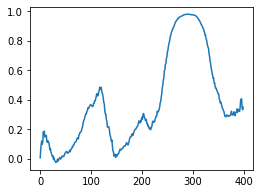

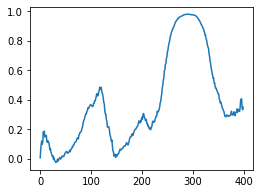

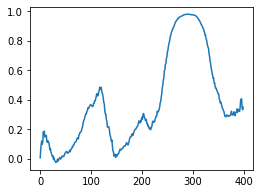

 45%|████▌     | 27/60 [01:22<00:53,  1.63s/it]

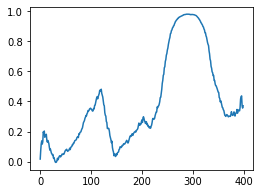

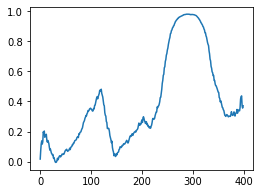

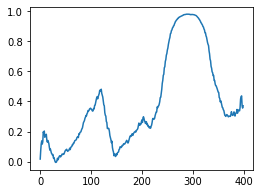

 47%|████▋     | 28/60 [01:23<00:51,  1.60s/it]

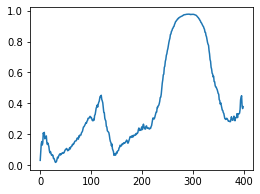

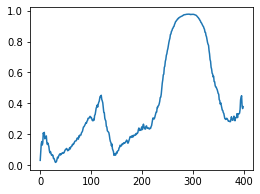

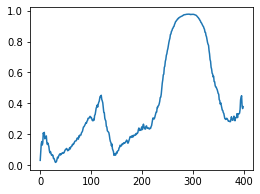

 48%|████▊     | 29/60 [01:25<00:49,  1.59s/it]

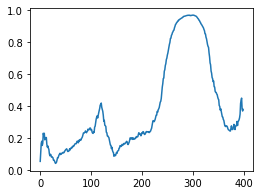

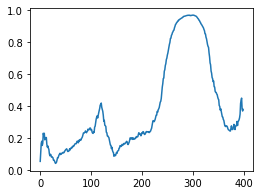

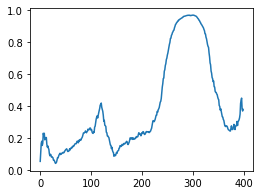

 50%|█████     | 30/60 [01:26<00:47,  1.57s/it]

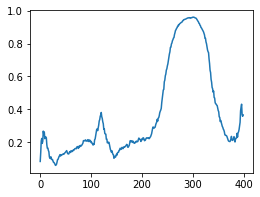

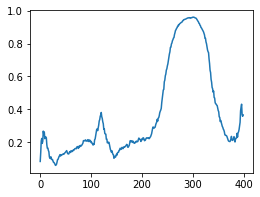

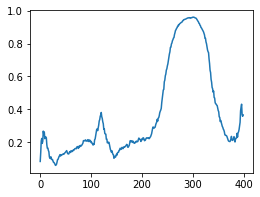

 52%|█████▏    | 31/60 [01:28<00:48,  1.66s/it]

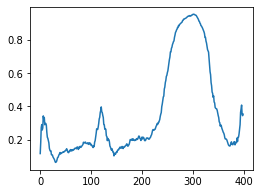

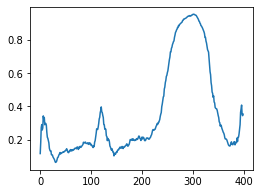

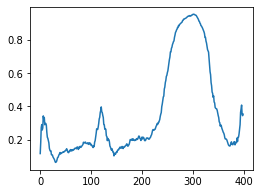

 53%|█████▎    | 32/60 [01:30<00:46,  1.66s/it]

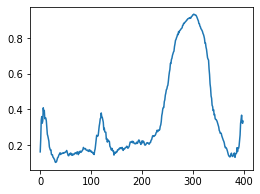

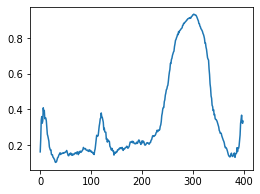

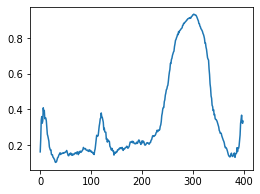

 55%|█████▌    | 33/60 [01:32<00:44,  1.64s/it]

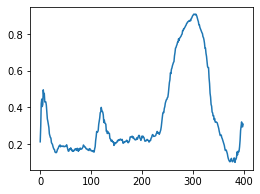

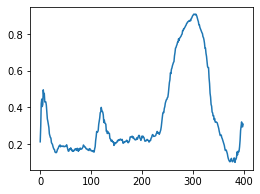

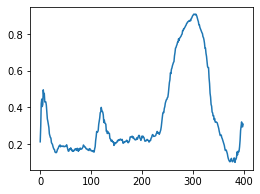

 57%|█████▋    | 34/60 [01:33<00:42,  1.62s/it]

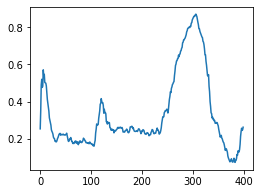

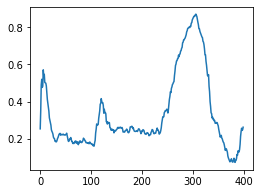

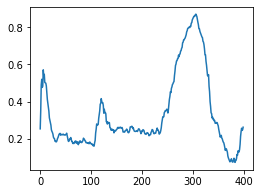

 58%|█████▊    | 35/60 [01:35<00:39,  1.59s/it]

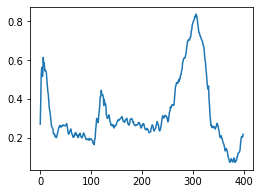

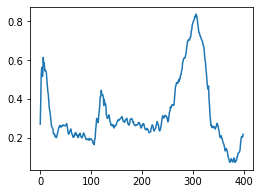

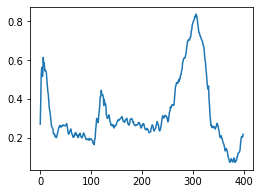

 60%|██████    | 36/60 [01:36<00:37,  1.58s/it]

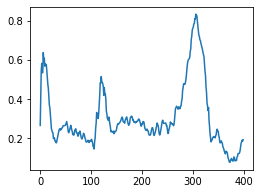

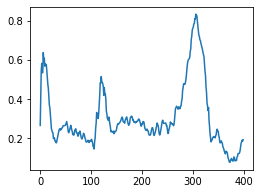

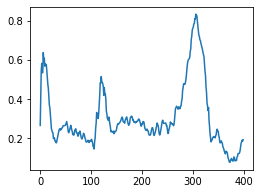

 62%|██████▏   | 37/60 [01:38<00:36,  1.57s/it]

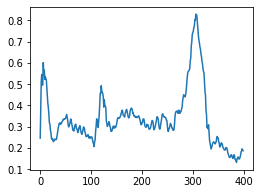

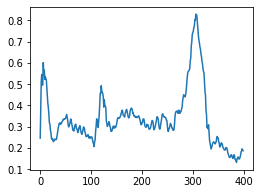

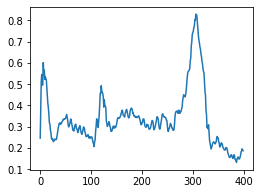

 63%|██████▎   | 38/60 [01:39<00:34,  1.58s/it]

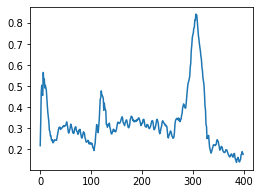

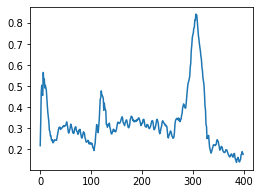

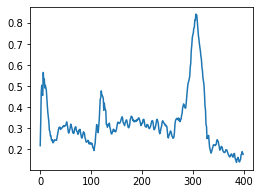

 65%|██████▌   | 39/60 [01:41<00:33,  1.58s/it]

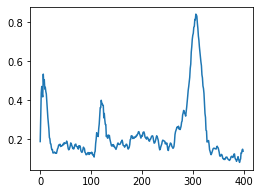

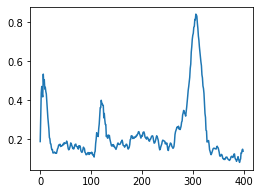

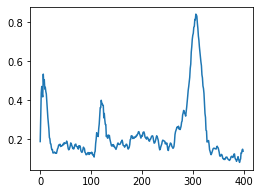

 67%|██████▋   | 40/60 [01:42<00:31,  1.58s/it]

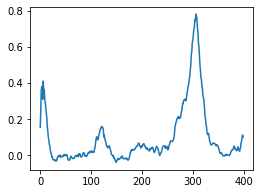

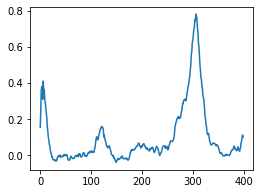

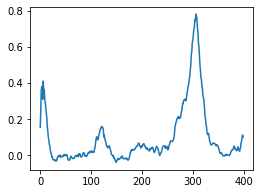

 68%|██████▊   | 41/60 [01:44<00:29,  1.57s/it]

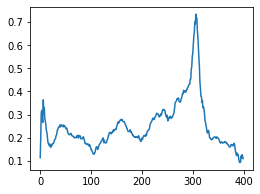

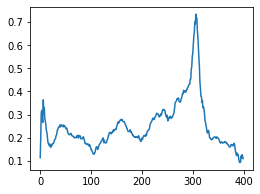

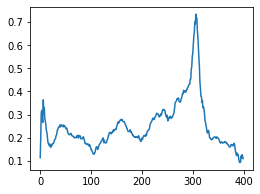

 70%|███████   | 42/60 [01:46<00:28,  1.58s/it]

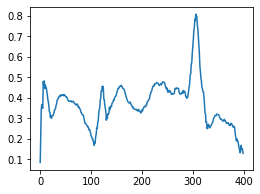

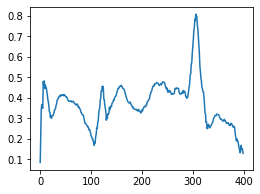

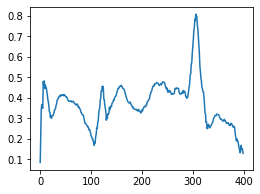

 72%|███████▏  | 43/60 [01:47<00:26,  1.58s/it]

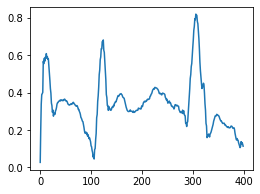

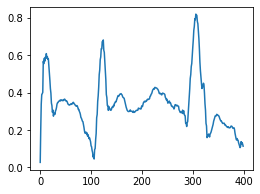

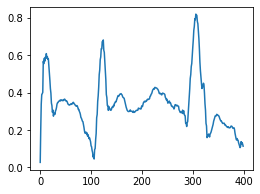

 73%|███████▎  | 44/60 [01:49<00:25,  1.59s/it]

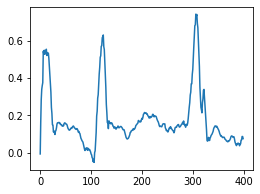

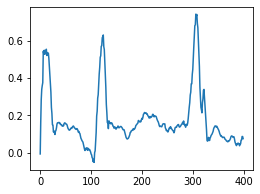

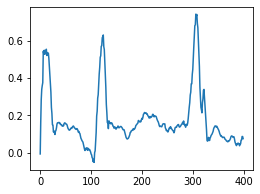

 75%|███████▌  | 45/60 [01:50<00:23,  1.58s/it]

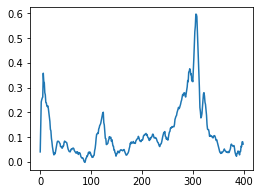

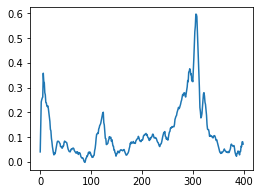

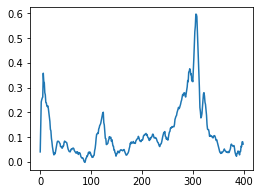

 77%|███████▋  | 46/60 [01:52<00:22,  1.58s/it]

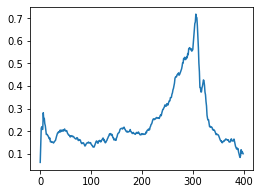

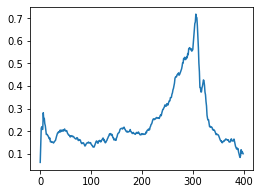

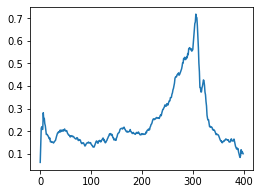

 78%|███████▊  | 47/60 [01:54<00:21,  1.69s/it]

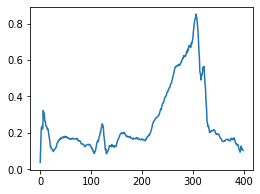

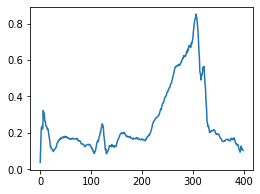

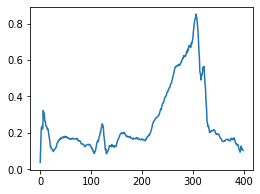

 80%|████████  | 48/60 [01:55<00:19,  1.65s/it]

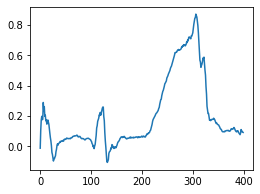

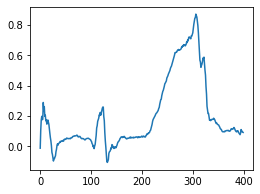

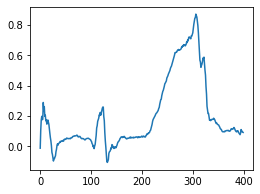

 82%|████████▏ | 49/60 [01:57<00:17,  1.63s/it]

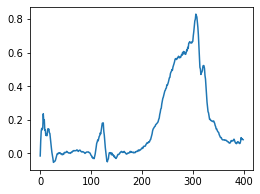

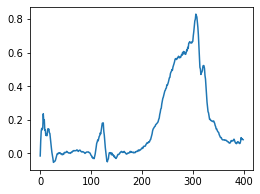

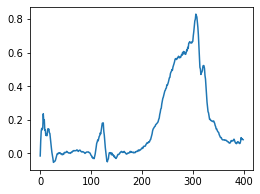

 83%|████████▎ | 50/60 [01:59<00:16,  1.62s/it]

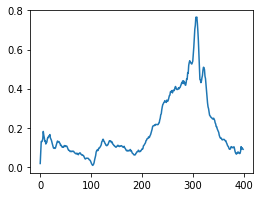

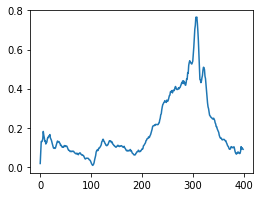

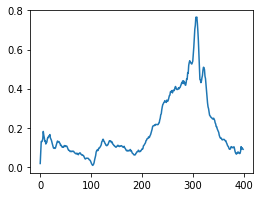

 85%|████████▌ | 51/60 [02:00<00:14,  1.61s/it]

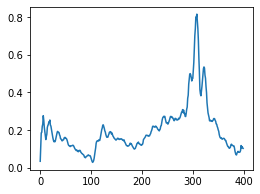

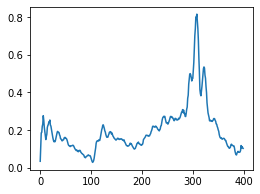

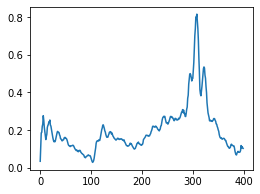

 87%|████████▋ | 52/60 [02:02<00:12,  1.60s/it]

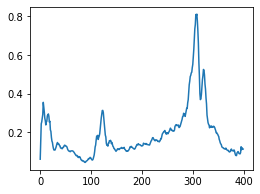

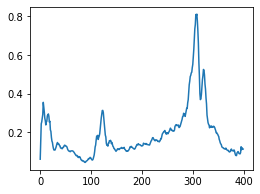

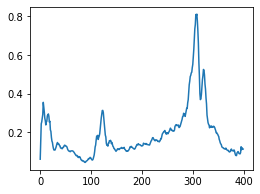

 88%|████████▊ | 53/60 [02:03<00:11,  1.59s/it]

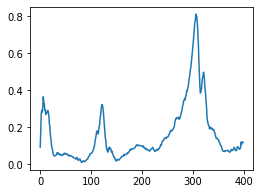

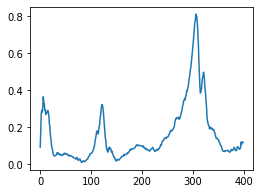

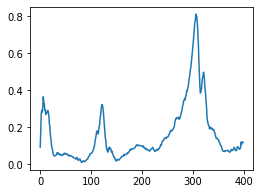

 90%|█████████ | 54/60 [02:05<00:09,  1.59s/it]

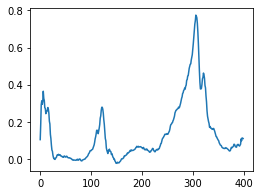

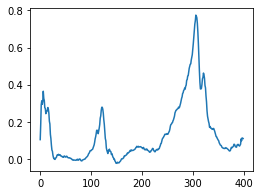

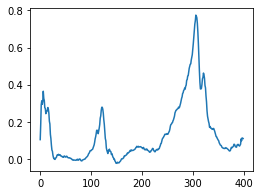

 92%|█████████▏| 55/60 [02:07<00:07,  1.59s/it]

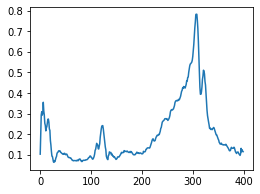

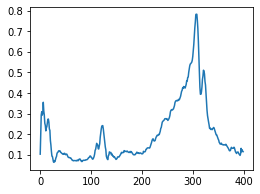

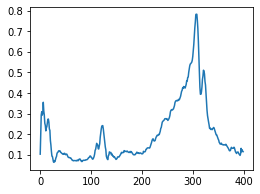

 93%|█████████▎| 56/60 [02:08<00:06,  1.59s/it]

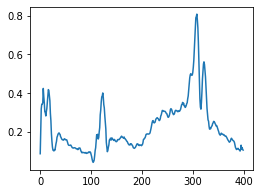

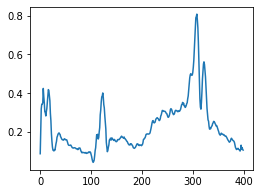

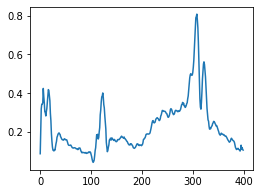

 95%|█████████▌| 57/60 [02:10<00:04,  1.58s/it]

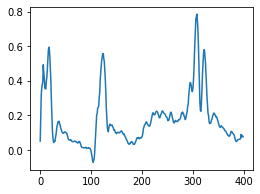

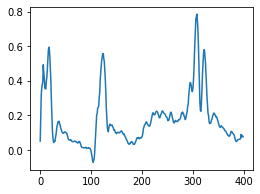

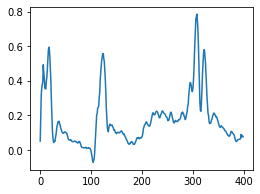

 97%|█████████▋| 58/60 [02:11<00:03,  1.58s/it]

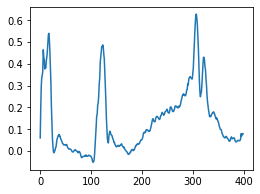

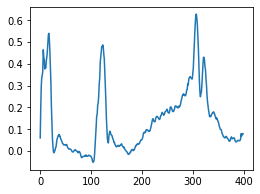

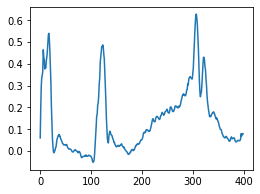

 98%|█████████▊| 59/60 [02:13<00:01,  1.58s/it]

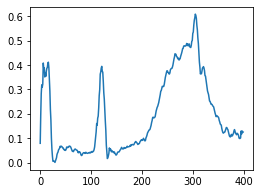

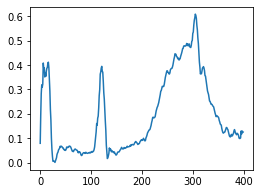

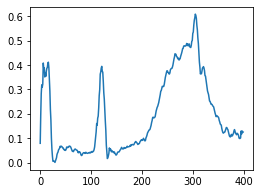

100%|██████████| 60/60 [02:14<00:00,  2.25s/it]


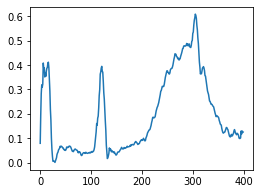

In [12]:
train(train_dataset, 60, noise_dim)

# Metrics Results

Here, we plot the metrics computed on the previous training of the models. 

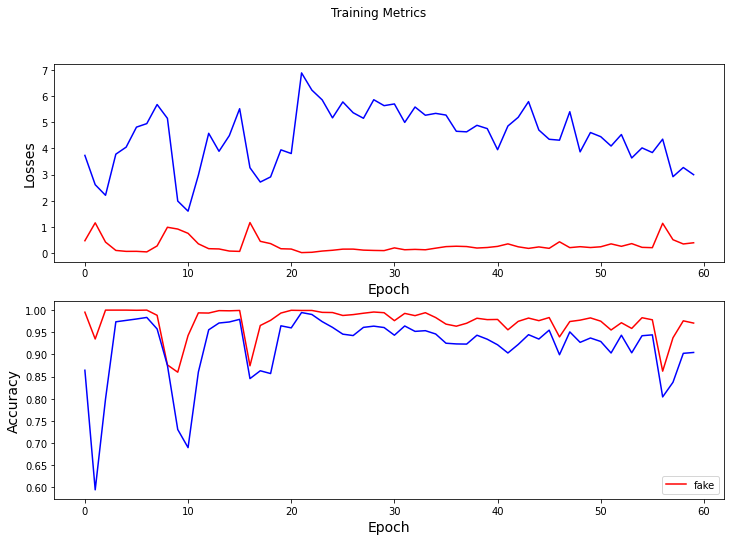

In [13]:
# %reload_ext tensorboard
# %tensorboard --logdir logs/gradient_tape

fig, axes = plt.subplots(2, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Losses", fontsize=14)
axes[0].set_xlabel("Epoch", fontsize=14)
axes[0].plot(disc_losses_list, color='red')
axes[0].plot(gen_losses_list, color='blue')

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(fake_disc_accuracy_list, color='red', label = 'fake')
axes[1].plot(real_disc_accuracy_list, color='blue')
plt.legend()
plt.show()

# ECG Results

Here, we compare side by side 20 signals from the generator model and the actual dataset. 

Data shape: (565, 1, 400)


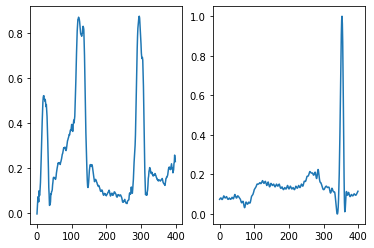

tf.Tensor([-0.5874391], shape=(1,), dtype=float32)


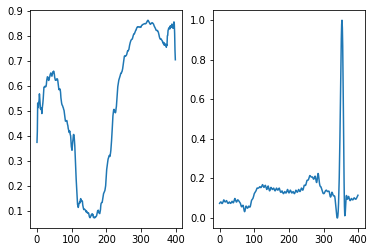

tf.Tensor([-2.0098922], shape=(1,), dtype=float32)


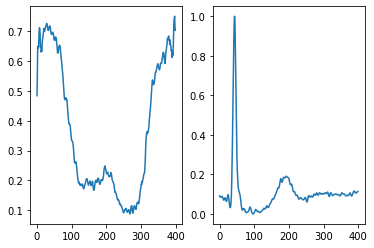

tf.Tensor([-0.590237], shape=(1,), dtype=float32)


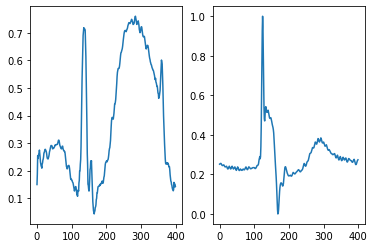

tf.Tensor([-4.4152355], shape=(1,), dtype=float32)


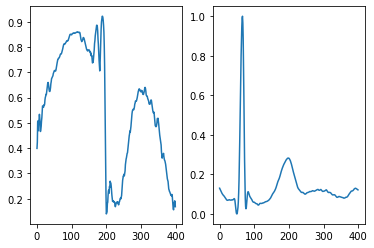

tf.Tensor([-3.993087], shape=(1,), dtype=float32)


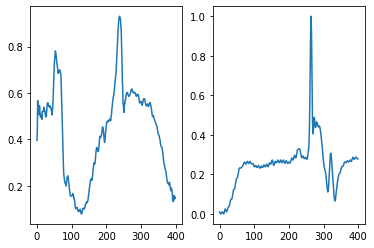

tf.Tensor([-4.76169], shape=(1,), dtype=float32)


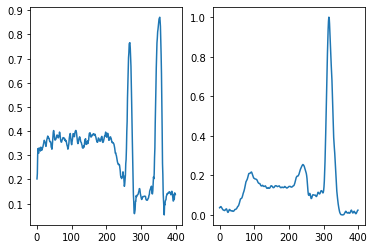

tf.Tensor([-1.2359185], shape=(1,), dtype=float32)


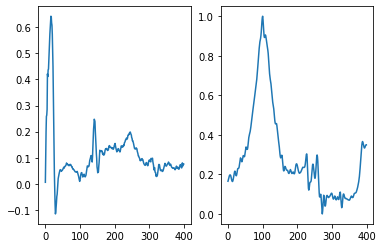

tf.Tensor([-4.233905], shape=(1,), dtype=float32)


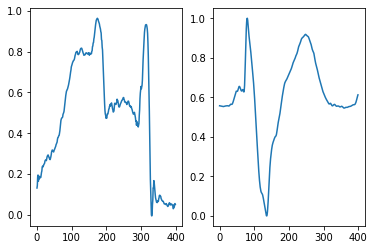

tf.Tensor([-3.1745563], shape=(1,), dtype=float32)


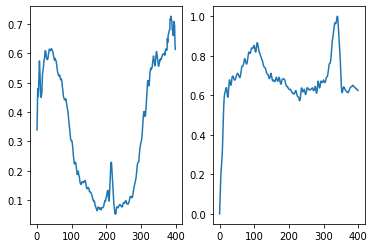

tf.Tensor([-3.0712705], shape=(1,), dtype=float32)


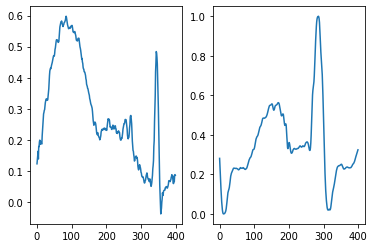

tf.Tensor([-3.0487401], shape=(1,), dtype=float32)


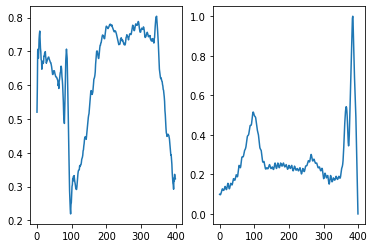

tf.Tensor([-3.98641], shape=(1,), dtype=float32)


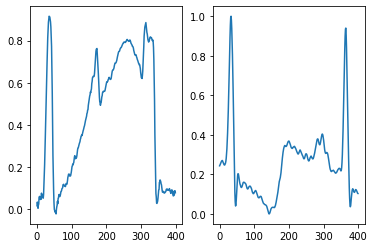

tf.Tensor([-1.7917417], shape=(1,), dtype=float32)


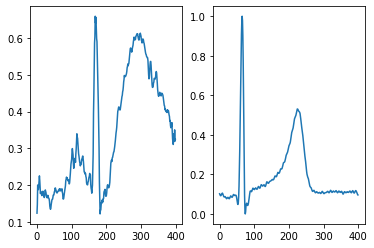

tf.Tensor([-4.9401817], shape=(1,), dtype=float32)


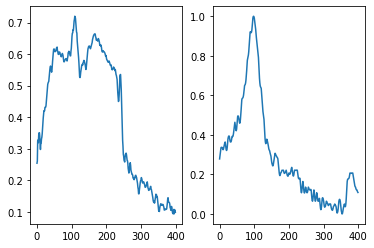

tf.Tensor([-4.327078], shape=(1,), dtype=float32)


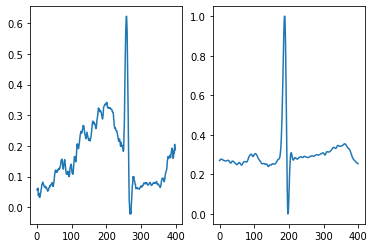

tf.Tensor([-3.4726403], shape=(1,), dtype=float32)


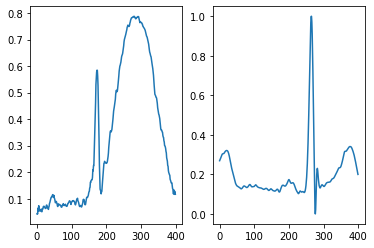

tf.Tensor([-4.517077], shape=(1,), dtype=float32)


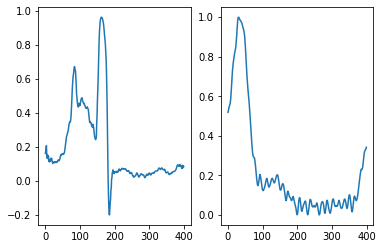

tf.Tensor([-1.1339742], shape=(1,), dtype=float32)


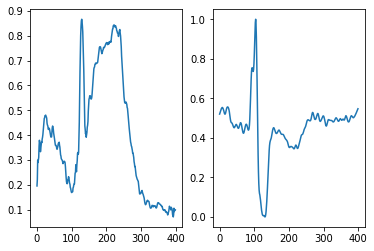

tf.Tensor([-2.8555613], shape=(1,), dtype=float32)


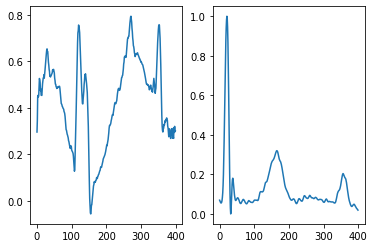

tf.Tensor([-3.018234], shape=(1,), dtype=float32)


In [14]:
mat = scipy.io.loadmat(r"/content/drive/MyDrive/Colab Notebooks/ecg_GAN/interp_data_norm.mat")

data = mat['interp_data'] 
data = np.reshape(data, (data.shape[0],1,data.shape[1]))


#data = np.load('./data/fix_signals_400.npy')
#data = np.reshape(data, (data.shape[0], 1, data.shape[1]))
print('Data shape:', data.shape)


data = data #/ norm_value # Normalize
data = np.array(data, dtype='float32')

for i in range(20):
  seed = tf.random.normal(noise_dim)
  ecg = generator(seed, training=False)
  answer = discriminator(ecg)
  fig, (ax1, ax2) = plt.subplots(1,2)
  ax1.plot(ecg[0, 0, :] * norm_value)
  ax2.plot(data[i][0])
  plt.show()
  print(answer[0])

# Save the models

In [15]:
generator.save('/drive/My Drive/Colab Notebooks/generator_80e.h5')
#test 
discriminator.save('/drive/My Drive/Colab Notebooks/discriminator_80e.h5')

#Load the generator model

In [16]:
model = tf.keras.models.load_model('/drive/My Drive/Colab Notebooks/generator_80e.h5')


# Convert the model to TF Lite

In this section, we use the built-in function of TensorFlow to convert our model to a TensorFlow Lite model of a smaller size. 

In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tfmodel = converter.convert()
open(MODEL_TFLITE, 'wb').write(tfmodel)



91320

# Resulting sizes of the models 

We print out the resulting sizes of the model before and after converting it to a TensorFlow Lite model. The first output is the TF Lite model size.

In [19]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File size: ' + str(round(size / 1024, 3)) + ' Kilobytes')
    elif unit == "MB":
        return print('File size: ' + str(round(size / (1024 * 1024), 3)) + ' Megabytes')
    else:
        return print('File size: ' + str(size) + ' bytes')
convert_bytes(get_file_size(MODEL_TFLITE), "KB")
convert_bytes(get_file_size('/drive/My Drive/Colab Notebooks/generator_80e.h5'), "KB")

File size: 89.18 Kilobytes
File size: 205.836 Kilobytes


In [21]:
interpreter = tf.lite.Interpreter(model_path = MODEL_TFLITE)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 100   1]
Input Type: <class 'numpy.float32'>
Output Shape: [  1   1 400]
Output Type: <class 'numpy.float32'>


In [22]:
#if you want to save the TF Lite model use below steps or else skip
tflite_model_files = pathlib.Path('/drive/My Drive/Colab Notebooks/pretrainedmodel.tflite')
tflite_model_files.write_bytes(tfmodel)
# Load TFLite model using interpreter and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tfmodel)
interpreter.allocate_tensors()

In [23]:


# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

  c_str = ''

  # Create header guard
  c_str += '#ifndef ' + var_name.upper() + '_H\n'
  c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
  c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
  c_str += 'unsigned char ' + var_name + '[] = {'
  hex_array = []
  for i, val in enumerate(hex_data) :

    # Construct string from hex
    hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
    if (i + 1) < len(hex_data):
      hex_str += ','
    if (i + 1) % 12 == 0:
      hex_str += '\n '
    hex_array.append(hex_str)

  # Add closing brace
  c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
  c_str += '#endif //' + var_name.upper() + '_H'

  return c_str



In [25]:


# Write TFLite model to a C source (or header) file
with open( 'ecg_model.h', 'w') as file:
  file.write(hex_to_c_array(tfmodel, 'ecg_model.h'))



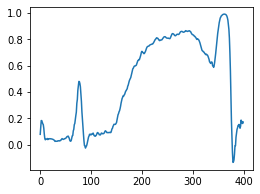

In [26]:
seed = tf.random.normal([1, 100, 1])
ecg = model(seed, training=False)
fig = plt.figure(figsize=(4,3))
plt.plot(ecg[0, 0, :] * norm_value)
plt.show()

In [24]:
#################################################################################
#          Testing functions
#################################################################################
def rmse(targets, predictions):
    return np.sqrt(np.mean((targets-predictions)**2))


def prd(targets, predictions):
    s1 = np.sum((targets-predictions)**2)
    s2 = np.sum(targets**2)
    return np.sqrt(s1 / s2 * 100)


def mmd(targets, predictions):
    mmd_stat = MMDStatistic(400, 400)
    sample_target = torch.from_numpy(targets.numpy().reshape((400,1)))
    sample_pred = torch.from_numpy(predictions.numpy().reshape((400,1)))
    
    stat = mmd_stat(sample_target, sample_pred, [1.])
    return(stat.item())


def testing(test_dataset, model, noise_dim):
    noise = tf.random.normal(noise_dim)
    generated_ecgs = model(noise, training=False)

    mmd_sum, prd_sum, rmse_sum = [], [], []
    for true_ecg, gen_ecg in zip(test_dataset, generated_ecgs):
        prd_sum.append(prd(true_ecg[0][0], gen_ecg[0]))
        rmse_sum.append(rmse(true_ecg[0][0], gen_ecg[0]))
        mmd_sum.append(mmd(true_ecg[0][0], gen_ecg[0]))

    print('mmd :', f'mean={np.mean(mmd_sum):.6f}', f'min={np.min(mmd_sum):.6f}', f'max={np.max(mmd_sum):.6f}')
    print('prd :', f'mean={np.mean(prd_sum):.4f}', f'min={np.min(prd_sum):.4f}', f'max={np.max(prd_sum):.4f}')
    print('rmse:', f'mean={np.mean(rmse_sum):.4f}', f'min={np.min(rmse_sum):.4f}', f'max={np.max(rmse_sum):.4f}')

In [27]:
testing(test_dataset, model, [763, 100, 1])

mmd : mean=0.063642 min=0.000556 max=0.348375
prd : mean=11.0991 min=5.0097 max=41.8445
rmse: mean=0.3165 min=0.1515 max=0.6116
